# Projeto 2 - CDados

### Autores: Diego Guimarães Nuñez, Felipe Bakowski Nantes de Souza, Gustavo de Lima Mota

### Tema: Conseguimos prever o número de homicídios nos municípios do Estado de SP em um ano qualquer ?

### Features: IDH por município, renda per capita, proporção de pessoas analfabetas com 15 anos ou mais, proporção de pessoas desocupadas com 18 anos ou mais e Índice de Gini por município.

### Fonte : basedosdados.org

 ### Bibliotecas utilizadas

In [136]:
import basedosdados as bd
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import numpy as np
from scipy import stats
from IPython.display import display
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import KFold 
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_predict
from sklearn.base import BaseEstimator, RegressorMixin

## Baixando as bases de dados utilizadas no projeto

### Para baixar essas bases, foi necessário baixar a biblioteca basedosdados e criar um projeto no Google Cloud. A primeira base é sobre o número de homícidios em cada município do Estado de São Paulo. Além disso, a segunda base é sobre o índice de vulnerabilidade social do município e traz diversas variáveis que são interessantes de estudar

In [137]:
homicidio = bd.read_table(dataset_id='br_sp_gov_ssp',
table_id='ocorrencias_registradas',
billing_project_id="cdadosp2-404421")

Downloading: 100%|██████████| 153876/153876 [00:27<00:00, 5603.00rows/s]


In [138]:
ivs = bd.read_table(dataset_id='br_ipea_avs',
table_id='municipio',
billing_project_id="cdadosp2-404421")

Downloading: 100%|██████████| 319681/319681 [09:42<00:00, 549.26rows/s] 


## Contextualização

### Refletindo sobre os problemas sociais presentes em São Paulo, um dos mais notáveis é a abundante taxa de criminalidade, especificando ainda mais, a taxa de homicídio. Visado a target (problema o qual é pretendido visualizar), foi-se pensado em possíveis features que estão ligadas com o tema tido em vista, as quais são: Índice de Gini, Indice de desenvolvimento Humano, proporção de populacao desocupada, proporção de pessoas analfabetas e Índice de Gini.

### Tendo em vista a target com suas respectivas features, é pretendido realizar a criação de dois modelos com capacidade de previsão para a criminalidade, entendendo intrinsicamente as relações individuais de cada feature com a target. A partir da criação deles, é facilitada a visão das 'raízes' do problema, possibilitando possíveis tomadas de decisões pessoais e governamentais para tratar esse severo problema.

### Por fim, planejamos fazer um modelo de regressão linear e um modelo de Machine Learning, usando Random Forest

 ## Análise exploratória

### Primeiramente, vamos tratar a base de dados de homicidios e deixá-la mais visualizável

In [139]:
homicidio['Homicidio_total'] = homicidio.loc[:, ['homicidio_doloso', 'homicidio_culposo_outros']].sum(axis=1) #homicidio total
homicidio_2010 = homicidio.loc[(homicidio['ano'] == 2010)]
homicidio_filtrado = homicidio_2010.loc[:,('ano','id_municipio', 'regiao_ssp', 'Homicidio_total')] #selecionando colunas
homicidio_ano = homicidio_filtrado.groupby(['ano', 'id_municipio', 'regiao_ssp']).agg({'Homicidio_total': 'sum'}).reset_index()

 ### Agora devemos tratar a base IVS, para que, consigamos utilizar as colunas:  'renda_per_capita', 'idhm' (IDH por municipio), 'proporcao_analfabetismo_15_mais', 'proporcao_sem_renda_18_mais', 'proporcao_sem_renda_18_mais'

In [140]:
#filtrando ivs
ivs_filtrado = ivs.loc[:,('ano','id_municipio','sigla_uf','idhm','renda_per_capita','proporcao_analfabetismo_15_mais', 'proporcao_sem_renda_18_mais','indice_gini')]
ivs_t = ivs_filtrado.loc[(ivs['sigla_uf'] == 'SP') & (ivs['ano'] == 2010)]
ivs_novo = ivs_t.dropna()
ivs_novo2 = ivs_novo.drop_duplicates(subset='id_municipio', keep = 'first')

### Então, juntaremos esses dois dataframes em uma grande tabela, para que seja possível trabalhar com as informações de maneira congrunete (mesmo número de linhas, municípios alinhados, etc)

### Nota: A capital São Paulo foi retirada da análise devido a motivos que iremos discutir depois

In [141]:
#criando tabela 
tabela_final = pd.merge(ivs_novo2, homicidio_ano[['id_municipio', 'Homicidio_total']], on='id_municipio', how='left')
tabela_definitiva = tabela_final.dropna()
tabela_definitiva.loc[tabela_definitiva['Homicidio_total']==1260] # identificando São Paulo
tabela_sem_sp = tabela_definitiva.drop(tabela_definitiva.loc[tabela_definitiva['Homicidio_total']==1260].index) # tirando São Paulo
tabela_sem_sp.describe()

,ano,idhm,renda_per_capita,proporcao_analfabetismo_15_mais,proporcao_sem_renda_18_mais,indice_gini,Homicidio_total
count,639.0,639.000000,639.000000,639.000000,639.000000,639.000000,639.000000
mean,2010.0,0.763746,802.356620,6.071049,3.066182,0.456135,5.244131
std,0.0,0.034519,240.292539,2.441283,2.853549,0.059192,13.881830
min,2010.0,0.655000,348.790000,1.010000,0.000000,0.320000,0.000000
25%,2010.0,0.742000,649.415000,4.280000,1.290000,0.410000,0.000000
50%,2010.0,0.763000,761.590000,5.840000,2.080000,0.450000,1.000000
75%,2010.0,0.785000,904.240000,7.485000,3.835000,0.490000,4.000000
max,2010.0,0.891000,2729.860000,17.090000,24.480000,0.740000,168.000000


### Agora deve-se dividir o nosso dataframe em treino e teste

In [142]:
tabela_sem_sp = tabela_sem_sp.sample(frac=1) #mudando a ordem das linhas, a fim de, garantir que os df estejam equilibrados

In [143]:
#nota : id_municipio não entra como feature, mas, coloca-se ele na base para ter uma manipulação mais fácil
X_treino_r, X_teste_r, y_treino_r, y_teste_r = train_test_split(tabela_sem_sp[['id_municipio','idhm','renda_per_capita','proporcao_analfabetismo_15_mais', 'proporcao_sem_renda_18_mais','indice_gini']], tabela_sem_sp['Homicidio_total'], test_size=0.2, random_state=42)

### Entendendo como a target (homicídio) se comporta em relação aos municípios

### De início, tem-se um crosstab que mostra quantos municípios tiveram X homicídios em 2010. Ademais, plotamos um gráfico de barras e um gráfico de disperção para obtermos elementos visuais que ajudam na análise

In [144]:
homicidio_mun = homicidio.groupby(['ano','id_municipio','regiao_ssp']).agg({'Homicidio_total': 'sum'}).reset_index()
homicidio_mun = homicidio_mun.loc[(homicidio_mun['regiao_ssp']!='Capital')] #retirando a capital
homicidio_mun_2010 = homicidio_mun.loc[homicidio_mun.ano == 2010]

In [145]:
pd.crosstab(homicidio_mun_2010.Homicidio_total, homicidio_mun_2010.id_municipio, margins=True).round(4)

id_municipio,3500105,3500204,3500303,3500402,3500501,3500550,3500600,3500709,3500758,3500808,...,3556701,3556800,3556909,3556958,3557006,3557105,3557154,3557204,3557303,All
Homicidio_total,,,,,,,,,,,,,,,,,,,,,
0.0,0,0,0,0,1,0,1,0,1,1,...,0,0,1,1,0,0,1,0,1,239
1.0,1,1,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,124
2.0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,58
3.0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,45
4.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,30
5.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,24
6.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,9
7.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
8.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6


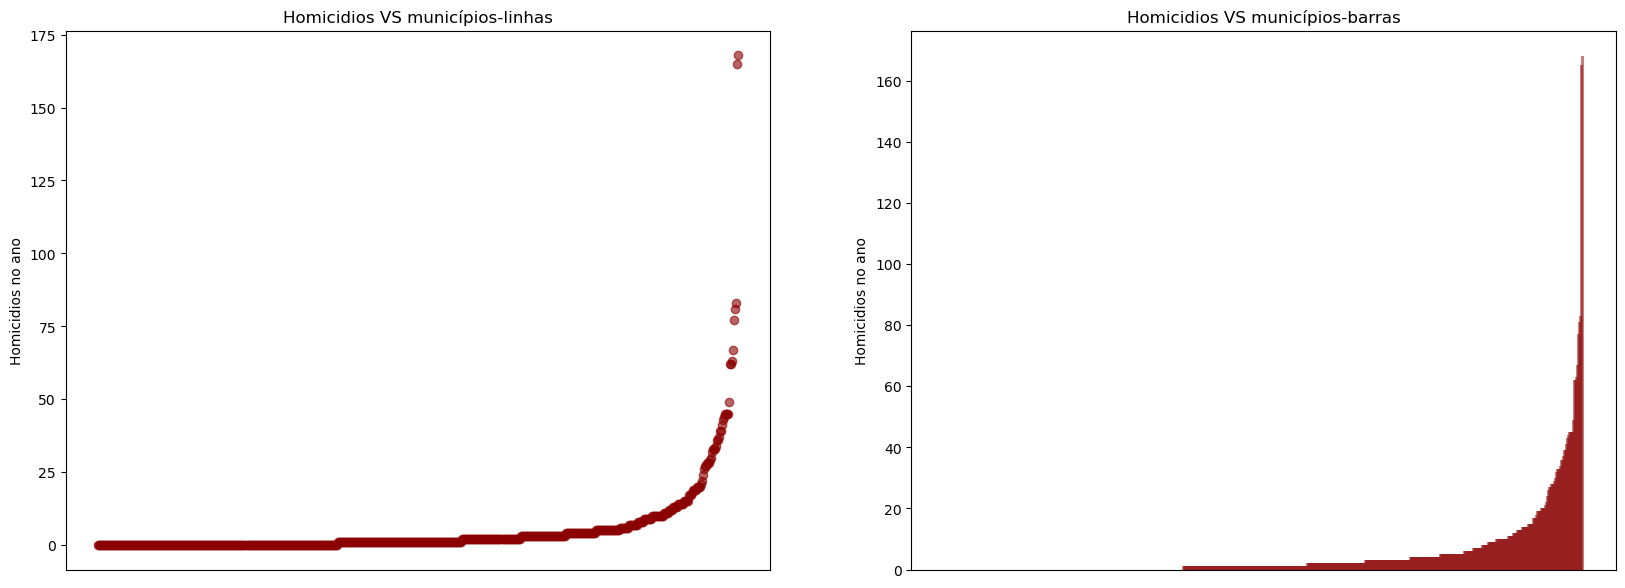

In [146]:
hom_ord = homicidio_mun_2010.sort_values('Homicidio_total')#ordenando os valores para ajudar na visibilidade

plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
plt.scatter(hom_ord.id_municipio, hom_ord.Homicidio_total, color='darkred', alpha=0.6)
plt.xlabel('Municípios')
plt.gca().axes.get_xaxis().set_visible(False) #retirando a legenda no eixo x, estava muito poluido
plt.ylabel('Homicidios no ano')
plt.title('Homicidios VS municípios-linhas')

plt.subplot(1,2,2)
plt.bar(hom_ord.id_municipio, hom_ord.Homicidio_total, color='darkred', width=3, alpha=0.5)
plt.xlabel('Municípios')
plt.gca().axes.get_xaxis().set_visible(False) #retirando a legenda no eixo x, estava muito poluido
plt.ylabel('Homicidios no ano')
plt.title('Homicidios VS municípios-barras')


plt.show()

 ### Então, deve-se entender as correlações entre as features e variáveis, para que seja possível diagnosticar futuros erros

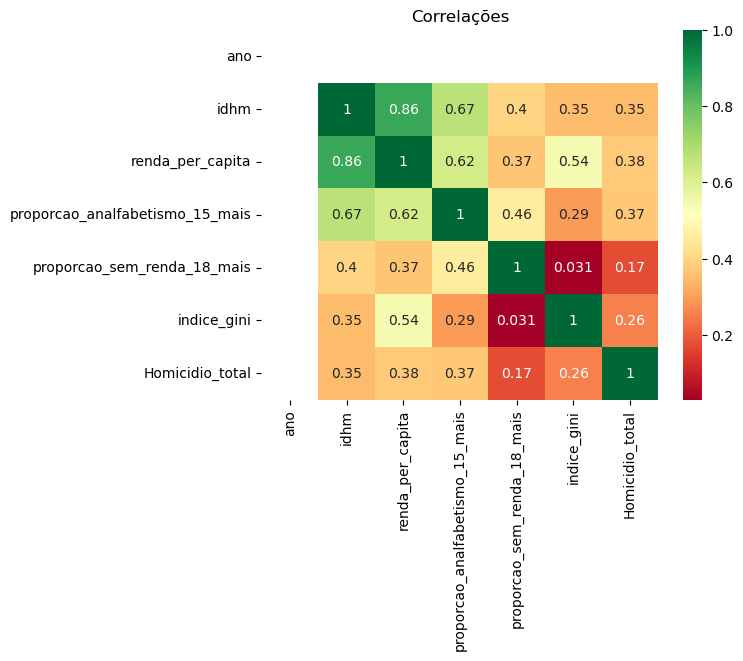

In [147]:
sns.heatmap(abs(tabela_sem_sp.corr()), annot = True, cmap= "RdYlGn") #nota : apenas para valores absolutos
plt.title('Correlações')
plt.show()

### Por fim, plota-se os gráficos de disperção de features VS target e mostra-se a correlação entre elas, respectivamente. Além disso, tem-se um boxplot do número de homicídios para visualizarmos como a nossa target se distribui

Correlação entre homicídios e idhm é moderada e possui valor de 0.3471078490441475
Correlação entre homicídios e renda per capita é moderada e possui valor de 0.3761556075810357
Correlação entre homicídios e prop. de analfabetismo é moderada e possui valor de -0.37168782422028257
Correlação entre homicídios e prop. pessoas sem renda é fraca e possui valor de -0.1733377810194883
Correlação entre homicídios e indice gini é fraca e possui valor de 0.2563769185726432


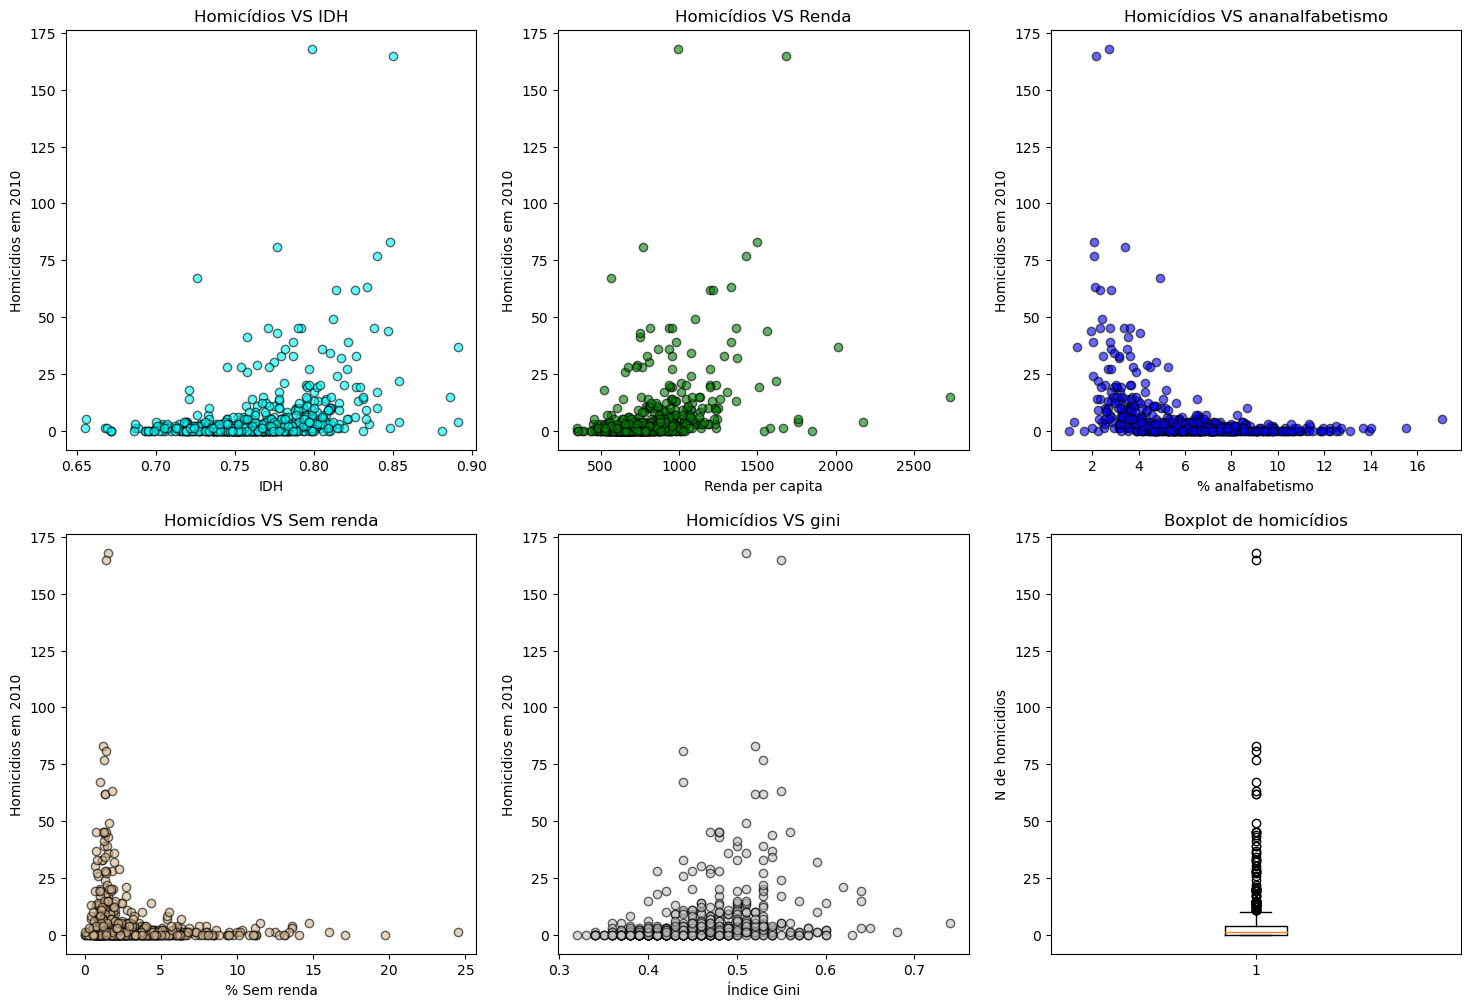

In [148]:
plt.figure(figsize=(18,12))

plt.subplot(2,3,1)
plt.scatter(tabela_sem_sp['idhm'], tabela_sem_sp['Homicidio_total'], alpha=0.6, color='cyan', edgecolors="black")
plt.xlabel('IDH')
plt.ylabel('Homicidios em 2010')
plt.title('Homicídios VS IDH')
corr_idhm = tabela_sem_sp['Homicidio_total'].corr(tabela_sem_sp['idhm'])
if abs(corr_idhm) < 0.3:
    print(f'Correlação entre homicídios e idhm é fraca e possui valor de {corr_idhm}')
elif abs(corr_idhm) >0.3 and (corr_idhm) < 0.7:
    print(f'Correlação entre homicídios e idhm é moderada e possui valor de {corr_idhm}')
elif abs(corr_idhm) > 0.7:
    print(f'Correlação entre homicídios e idhm é forte e possui valor de {corr_idhm}')

plt.subplot(2,3,2)
plt.scatter(tabela_sem_sp['renda_per_capita'], tabela_sem_sp['Homicidio_total'], alpha=0.6, color='green', edgecolors="black")
plt.xlabel('Renda per capita')
plt.ylabel('Homicidios em 2010')
plt.title('Homicídios VS Renda')
corr_renda = tabela_sem_sp['Homicidio_total'].corr(tabela_sem_sp['renda_per_capita'])
if abs(corr_renda) < 0.3:
    print(f'Correlação entre homicídios e renda per capita é fraca e possui valor de {corr_renda}')
elif abs(corr_renda) >0.3 and (corr_renda) < 0.7:
    print(f'Correlação entre homicídios e renda per capita é moderada e possui valor de {corr_renda}')
elif abs(corr_renda) > 0.7:
    print(f'Correlação entre homicídios e renda per capita é forte e possui valor de {corr_renda}')

plt.subplot(2,3,3)
plt.scatter(tabela_sem_sp['proporcao_analfabetismo_15_mais'], tabela_sem_sp['Homicidio_total'], alpha=0.6, color='blue', edgecolors="black")
plt.xlabel('% analfabetismo')
plt.ylabel('Homicidios em 2010')
plt.title('Homicídios VS ananalfabetismo')
corr_analfab = tabela_sem_sp['Homicidio_total'].corr(tabela_sem_sp['proporcao_analfabetismo_15_mais'])
if abs(corr_analfab) < 0.3:
    print(f'Correlação entre homicídios e prop. de analfabetismo é fraca e possui valor de {corr_analfab}')
elif abs(corr_analfab) >0.3 and (corr_analfab) < 0.7:
    print(f'Correlação entre homicídios e prop. de analfabetismo é moderada e possui valor de {corr_analfab}')
elif abs(corr_analfab) > 0.7:
    print(f'Correlação entre homicídios e prop. de analfabetismo é forte e possui valor de {corr_analfab}')

plt.subplot(2,3,4)
plt.scatter(tabela_sem_sp['proporcao_sem_renda_18_mais'], tabela_sem_sp['Homicidio_total'], alpha=0.6, color='tan', edgecolors="black")
plt.xlabel('% Sem renda')
plt.ylabel('Homicidios em 2010')
plt.title('Homicídios VS Sem renda')
corr_sem_renda = tabela_sem_sp['Homicidio_total'].corr(tabela_sem_sp['proporcao_sem_renda_18_mais'])
if abs(corr_sem_renda) < 0.3:
    print(f'Correlação entre homicídios e prop. pessoas sem renda é fraca e possui valor de {corr_sem_renda}')
elif abs(corr_sem_renda) >0.3 and (corr_sem_renda) < 0.7:
    print(f'Correlação entre homicídios e prop. pessoas sem renda é moderada e possui valor de {corr_sem_renda}')
elif abs(corr_sem_renda) > 0.7:
    print(f'Correlação entre homicídios e prop. pessoas sem renda é forte e possui valor de {corr_sem_renda}')

plt.subplot(2,3,5)
plt.scatter(tabela_sem_sp['indice_gini'], tabela_sem_sp['Homicidio_total'], alpha=0.6, color='silver', edgecolors="black")
plt.xlabel('Índice Gini')
plt.ylabel('Homicidios em 2010')
plt.title('Homicídios VS gini')
corr_gini = tabela_sem_sp['Homicidio_total'].corr(tabela_sem_sp['indice_gini'])
if abs(corr_gini) < 0.3:
    print(f'Correlação entre homicídios e indice gini é fraca e possui valor de {corr_gini}')
elif abs(corr_gini) >0.3 and (corr_gini) < 0.7:
    print(f'Correlação entre homicídios e indice gini é moderada e possui valor de {corr_gini}')
elif abs(corr_gini) > 0.7:
    print(f'Correlação entre homicídios e indice gini é forte e possui valor de {corr_gini}')

plt.subplot(2,3,6)
plt.boxplot(tabela_sem_sp['Homicidio_total'])
plt.title('Boxplot de homicídios')
plt.ylabel('N de homicidios')

plt.show()

### Possíveis fontes de erro:

### Alguns municípios tem pontos muito aberrantes e fazem com que a análise não seja tão precisa. Um caso que exemplifica bem esse ponto é a capital São Paula, enquanto os outros municípios não passavam de 200 homicídios, aquela estava com 1260 e causava grande desequilíbrio na análise. Logo, julgamos que foi melhor retirá-la

### Agora iremos criar um modelo de regressão linear com múltiplas variáveis, utilizando o df treino

In [175]:
#funções e classes utilizadas na regressão
def regress(Y,X):
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    
    return results

class StatsmodelsWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model
    
    def fit(self, X, y):
        X_cp = sm.add_constant(X)
        self.model = self.model(y, X_cp).fit()
        return self
    
    def predict(self, X):
        X_cp = sm.add_constant(X)
        return self.model.predict(X_cp)

In [150]:
X = X_treino_r[['idhm','renda_per_capita','proporcao_analfabetismo_15_mais', 'proporcao_sem_renda_18_mais','indice_gini']]

Y = y_treino_r

In [151]:
modelo_regress = regress(Y, X)

modelo_regress.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Homicidio_total   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     18.38
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           8.73e-17
Time:                        12:39:53   Log-Likelihood:                -2045.9
No. Observations:                 511   AIC:                             4104.
Df Residuals:                     505   BIC:                             4129.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                             -10.2670     27.738     -0.370      0.711     -64.762      44.228
idhm                               10.5085     37.044      0.284      0.777     -62.271      83.288
renda_per_capita                    0.0065      0.006      1.188      0.235      -0.004       0.017
proporcao_analfabetismo_15_mais    -1.4102      0.359     -3.932      0.000      -2.115      -0.706
proporcao_sem_renda_18_mais        -0.0916      0.243     -0.377      0.707      -0.569       0.386
indice_gini                        23.7996     12.551      1.896      0.058      -0.858      48.458
==============================================================================
Omnibus:                      691.535   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           100908.825
Skew:                           6.909   Prob(JB):                         0.00
Kurtosis:                      70.442   Cond. No.                     6.66e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.66e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Então, precisamos analisar quais variáveis serão desejáveis para a análise. Para isso iremos utilizar um processo iterativo de rodar o modelo e avaliar se o valor P está acima de 10% (índice de significância), caso esteja, ele deverá ser retirado e rodaremos o modelo denovo até que achemos todas as variáveis relevantes.

In [152]:
X = X_treino_r[['idhm','renda_per_capita','proporcao_analfabetismo_15_mais','indice_gini']]

Y = y_treino_r

In [153]:
modelo_regress = regress(Y, X)

modelo_regress.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Homicidio_total   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     22.98
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           1.81e-17
Time:                        12:39:53   Log-Likelihood:                -2045.9
No. Observations:                 511   AIC:                             4102.
Df Residuals:                     506   BIC:                             4123.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -9.7248     27.677     -0.351      0.725     -64.100      44.651
idhm                               10.1640     37.001      0.275      0.784     -62.531      82.859
renda_per_capita                    0.0069      0.005      1.281      0.201      -0.004       0.018
proporcao_analfabetismo_15_mais    -1.4485      0.344     -4.216      0.000      -2.124      -0.773
indice_gini                        22.3943     11.973      1.870      0.062      -1.129      45.917
==============================================================================
Omnibus:                      691.019   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           100519.327
Skew:                           6.900   Prob(JB):                         0.00
Kurtosis:                      70.310   Cond. No.                     6.66e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.66e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [154]:
X = X_treino_r[['renda_per_capita','proporcao_analfabetismo_15_mais','indice_gini']]

Y = y_treino_r

In [155]:
modelo_regress = regress(Y, X)

modelo_regress.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Homicidio_total   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     30.67
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           3.09e-18
Time:                        12:39:53   Log-Likelihood:                -2046.0
No. Observations:                 511   AIC:                             4100.
Df Residuals:                     507   BIC:                             4117.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -2.2751      5.516     -0.412      0.680     -13.113       8.563
renda_per_capita                    0.0081      0.003      2.359      0.019       0.001       0.015
proporcao_analfabetismo_15_mais    -1.4823      0.320     -4.626      0.000      -2.112      -0.853
indice_gini                        21.5099     11.521      1.867      0.062      -1.126      44.146
==============================================================================
Omnibus:                      690.590   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           100246.243
Skew:                           6.893   Prob(JB):                         0.00
Kurtosis:                      70.217   Cond. No.                     1.76e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.76e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [156]:
X = X_treino_r[['renda_per_capita','proporcao_analfabetismo_15_mais']]

Y = y_treino_r

In [157]:
modelo_regress = regress(Y, X)

modelo_regress.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Homicidio_total   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     44.05
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           2.27e-18
Time:                        12:39:53   Log-Likelihood:                -2047.7
No. Observations:                 511   AIC:                             4101.
Df Residuals:                     508   BIC:                             4114.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               4.8747      3.980      1.225      0.221      -2.945      12.694
renda_per_capita                    0.0111      0.003      3.671      0.000       0.005       0.017
proporcao_analfabetismo_15_mais    -1.4423      0.320     -4.500      0.000      -2.072      -0.813
==============================================================================
Omnibus:                      688.463   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            98472.903
Skew:                           6.859   Prob(JB):                         0.00
Kurtosis:                      69.609   Cond. No.                     5.75e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Agora que apenas as features relevantes sobraram, devemos análisar a correlação entre os erros do modelo. Para isso, utilizaremos o valor de Durbin-Watson.

### No caso, esse valor é de 1,999

In [158]:
resultado = 2*(1-1.999)

In [159]:
resultado

-1.9900000000000002

### Como esse resultado está muito próximo de 2, pode-se afirmar que a correlação entre os erros é bem baixa !

### Agora, nós podemos fazer uma análise da nossa regressão linear composta e avaliar se ela responde a nossa pergunta inicial. Para isso, iremos calcular a diferença entre os valores reais e os criados pelo modelo, a fim de, realizar uma análise exploratória neles e compreender seu funcionamento

In [160]:
y = modelo_regress.predict() #coletando valores previtos

#criando um df grande com todos os valores desejados para a análise
X_treino_r['Homicidio_total'] = pd.Series(y_treino_r)
X_teste_r['Homicidio_total'] = pd.Series(y_treino_r)
df_modelo1 = X_treino_r.loc[:, ('id_municipio', 'Homicidio_total', 'proporcao_analfabetismo_15_mais','renda_per_capita')]
df_modelo1['y'] = y
df_modelo1['diferença'] = df_modelo1.Homicidio_total-df_modelo1.y
df_modelo1 = df_modelo1.sort_values('diferença')

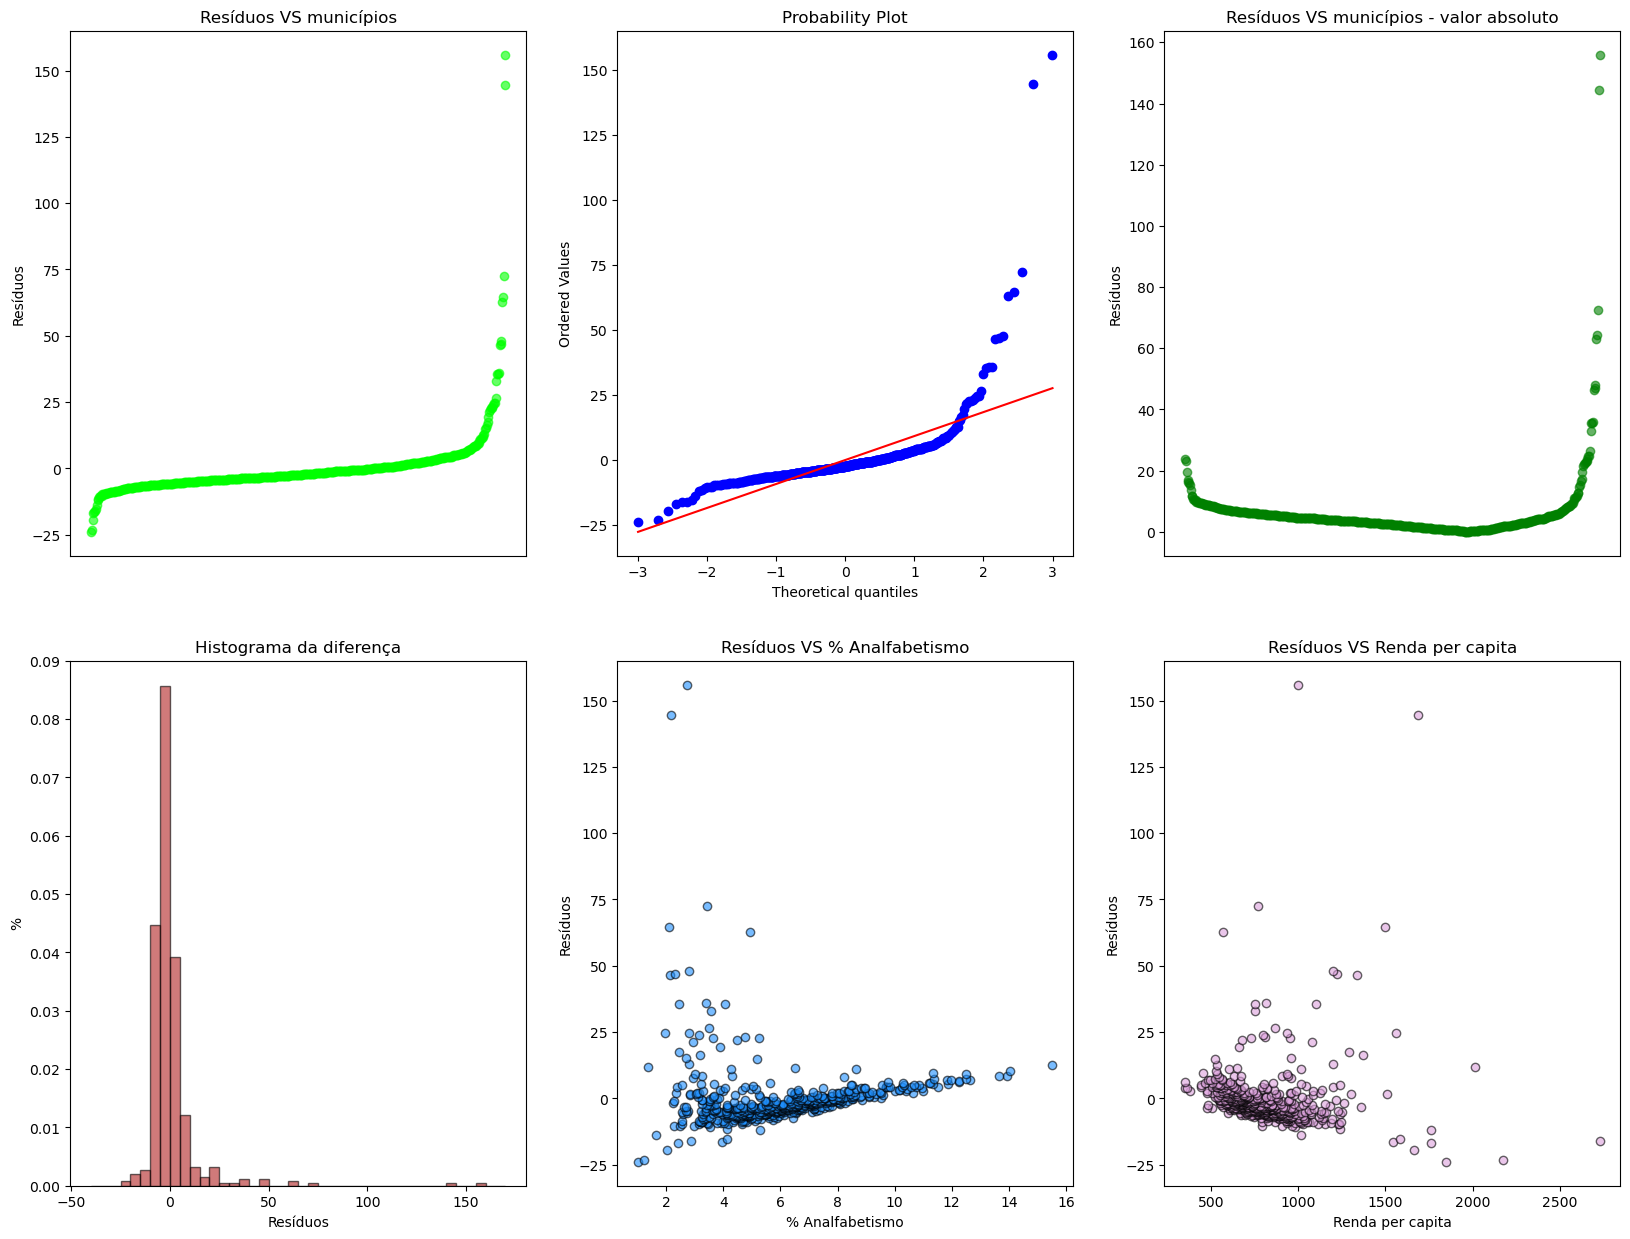

In [161]:
%matplotlib inline
plt.figure(figsize=(20,15))

#diferença entre os dois modelos
plt.subplot(2,3,1)
plt.scatter(df_modelo1.id_municipio, df_modelo1.diferença, color='lime', alpha=0.6)
plt.gca().axes.get_xaxis().set_visible(False) #retirando a legenda no eixo x, estava muito poluido
plt.ylabel('Resíduos')
plt.title('Resíduos VS municípios')

#probplot dos resíduis
plt.subplot(2,3,2)
stats.probplot(df_modelo1.diferença, dist='norm', plot=plt)

#diferença vc municípios em absoluto
plt.subplot(2,3,3)
plt.scatter(df_modelo1.id_municipio, abs(df_modelo1.diferença), color='g', alpha=0.6)
plt.gca().axes.get_xaxis().set_visible(False) #retirando a legenda no eixo x, estava muito poluido
plt.ylabel('Resíduos')
plt.title('Resíduos VS municípios - valor absoluto')

#Histograma da diferença
plt.subplot(2,3,4)
bins = np.arange(-40, 175, 5)
plt.hist(df_modelo1.diferença, bins=bins, density=True, color='firebrick', edgecolor='black', alpha=0.6)
plt.ylabel('%')
plt.xlabel('Resíduos')
plt.title('Histograma da diferença')

#Diferença vs analfabetismo
plt.subplot(2,3,5)
plt.scatter(df_modelo1.proporcao_analfabetismo_15_mais, df_modelo1.diferença, color='dodgerblue', alpha=0.6, edgecolors='black')
plt.ylabel('Resíduos')
plt.xlabel('% Analfabetismo')
plt.title('Resíduos VS % Analfabetismo')

#Diferença vs renda per capita
plt.subplot(2,3,6)
plt.scatter(df_modelo1.renda_per_capita, df_modelo1.diferença, color='plum', alpha=0.6, edgecolors='black')
plt.ylabel('Resíduos')
plt.xlabel('Renda per capita')
plt.title('Resíduos VS Renda per capita')

plt.show()

 ### Fazendo um mapa de calor para melhor visualizar as correlações

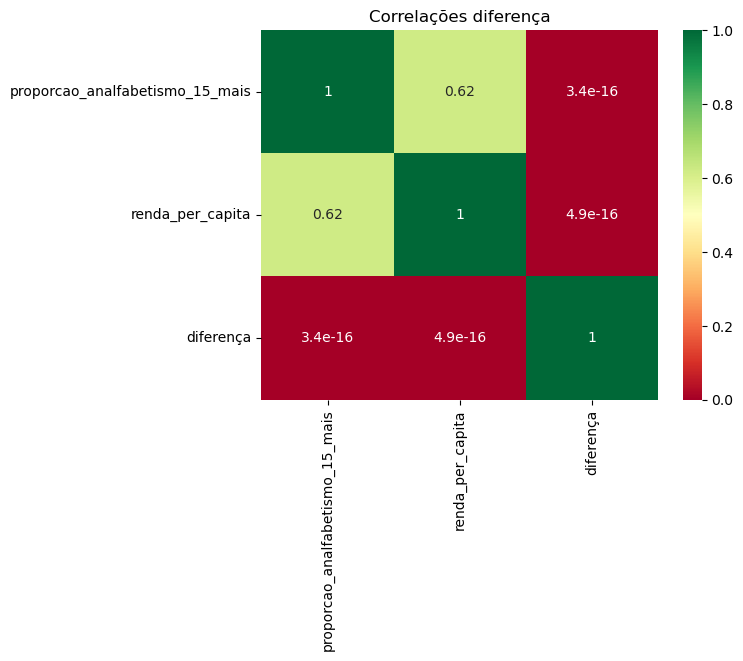

In [162]:
heatmap = df_modelo1.loc[:, ('proporcao_analfabetismo_15_mais', 'renda_per_capita', 'diferença')]
sns.heatmap(abs(heatmap.corr()), annot = True, cmap= "RdYlGn") #nota : apenas para valores absolutos
plt.title('Correlações diferença')
plt.show()

### Nota-se que a correlação entre os resíduos e as features são baixas, fato que é bom, pois, demonstro que existe pouco correlação entre os erros

 ### Agora, iremos plotar um gráfico 3D da diferença entre modelos (z) com suas features no x e y. Entretanto, para visualizá-lo deve-se abrir o arquivo no jupyter

In [163]:
beta0_hat = modelo_regress.params[0]  
beta1_hat = modelo_regress.params[1]  
beta2_hat = modelo_regress.params[2]  

def f(feature1, feature2):
    return beta0_hat + beta1_hat*feature1 + beta2_hat*feature2

In [164]:
%matplotlib notebook

npoints = 100
feature1 = df_modelo1['renda_per_capita']
feature2 = df_modelo1['proporcao_analfabetismo_15_mais']
x_vc = np.linspace(feature1.min(), feature1.max(), npoints)
y_vc = np.linspace(feature2.min(), feature2.max(), npoints)

eixo_x, eixo_y = np.meshgrid(x_vc, y_vc)

fit_z = f(eixo_x, eixo_y)

plt3d = plt.subplot(projection='3d')
plt3d.plot_surface(eixo_x, eixo_y, fit_z)
plt3d.scatter(feature1, feature2, Y, color="r")
plt3d.set_xlabel("Renda per capita")
plt3d.set_ylabel("Proporção Analfabetismo")
plt3d.set_zlabel("Previsão")
plt.show()

<IPython.core.display.Javascript object>

 ## Aplicando validação cruzada na regressão

 ### Nesse método, divide-se o conjunto em 10 subconjuntos(ciclos) e treiná-o em conjunto para ele ser testado em outra parte. Assim, obtêm-se um método confiável de avaliar o desempenho do modelo

In [235]:
X = df_modelo1[['renda_per_capita', 'proporcao_analfabetismo_15_mais']]
y = df_modelo1['Homicidio_total']

wrapper_model = StatsmodelsWrapper(sm.OLS) #essa clase basicamente serve para colocar o modelo em um formato aceitável para as funções processarem

y_pred_cv = cross_val_predict(wrapper_model, X, y, cv=10)  # cv é o número de folds (k) ou ciclos

rmse = np.sqrt(mean_squared_error(y, y_pred_cv))

print("RMSE durante a validação cruzada:", rmse) #desvio padrão dos valores residuais

RMSE durante a validação cruzada: 15.405341691735366


### O valor RMSE significa o desvio padrão dos resíduos(diferença entre previsto e real). Então, como ele é um valor relativamente alto, deduz-se que a nossa regressão não é a mais eficiente para prever a target


 ### Observando como o modelo se comporta em uma base nova

 ### Nota: caso essa célula não rode, apenas rode a anterior e imediatamente rode esta

In [236]:
X_teste = X_teste_r[['renda_per_capita', 'proporcao_analfabetismo_15_mais']]
y_teste = y_teste_r

#retirando valores não desejados
imputer = SimpleImputer(strategy='mean')
X_teste_imputed = imputer.fit_transform(X_teste)

# escalonando para evitar dados imensos
scaler = StandardScaler()
X_teste_scaled = scaler.fit_transform(X_teste_imputed)

#colocando no modelo certo com a variáel da célula anteriror
wrapper_model.fit(X, y)

#realizando a previsão para df_teste
y_pred_teste = wrapper_model.predict(X_teste_scaled)

# Calcular o RMSE no conjunto de testes
rmse_teste = np.sqrt(mean_squared_error(y_teste, y_pred_teste))

print("RMSE no conjunto de testes:", rmse_teste)

RMSE no conjunto de testes: 10.820313630083897


### Agora que testamos nosso modelo em uma base nova, fica mais claro a afirmação anterior, a média de erros ao quadrado está muito grande, fato que elucida ainda mais a ineficiência desse modelo

## Com a nossa regressão linear completa, agora devemos utilizar uma segunda técnica de predição para criar um outro modelo. Esta será feito através da biblioteca Random Forest

### Primeiro deve-se criar mais uma divisão entre treino e teste

In [168]:
X_train, X_test, y_train, y_test = train_test_split(tabela_sem_sp[['idhm','renda_per_capita','proporcao_analfabetismo_15_mais','proporcao_sem_renda_18_mais','indice_gini']], tabela_sem_sp['Homicidio_total'], test_size=0.3, random_state=0)

### Escolhendo 1000 árvores para o modelo

In [169]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 1000, random_state = 42)
regressor.fit(X_train, y_train) #utilizando a base de treino para criar um modelo

RandomForestRegressor(n_estimators=1000, random_state=42)

### Previsão, vendo como o modelo se comporta em relação à um df novo

In [170]:
y_pred = regressor.predict(X_test)
df=pd.DataFrame({'Homicídios reais':y_test, 'Previsão':y_pred}) 
df

,Homicídios reais,Previsão
87,1.0,1.425
432,1.0,3.194
438,2.0,3.971
406,0.0,0.719
514,1.0,0.601
...,...,...
215,1.0,1.212
164,2.0,1.161
421,2.0,0.386
81,4.0,1.806


### Validação

In [171]:
print('Média absoluta dos erros:', metrics.mean_absolute_error(y_test, y_pred))
print('Média absoluta ao quadrado dos erros:', metrics.mean_squared_error(y_test, y_pred))
print('Raíz da média absoluta ao quadrado dos erros:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Média absoluta dos erros: 4.216432291666666
Média absoluta ao quadrado dos erros: 81.60856584895832
Raíz da média absoluta ao quadrado dos erros: 9.033745947775946


### Comparação de df teste e modelo

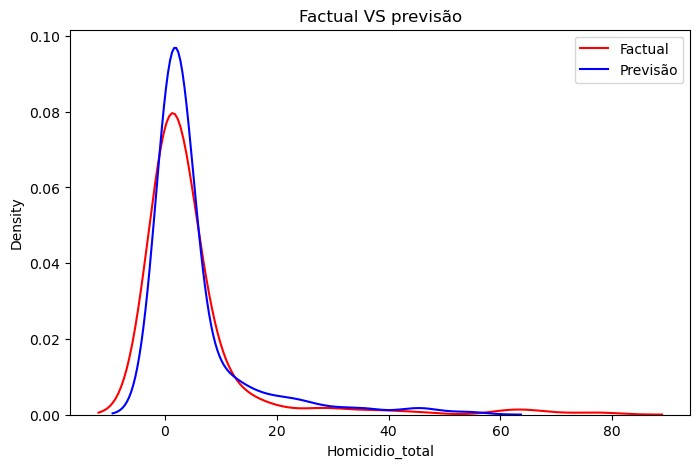

In [172]:
%matplotlib inline
plt.figure(figsize=(8, 5))


ax = sns.distplot(y_test, hist=False, color="r", label="Factual")
sns.distplot(y_pred, hist=False, color="b", label="Previsão" , ax=ax)


plt.title('Factual VS previsão')

plt.legend()
plt.show()
plt.close()

### Visualizando como uma árvore pode se ramificar e convergir em um ponto

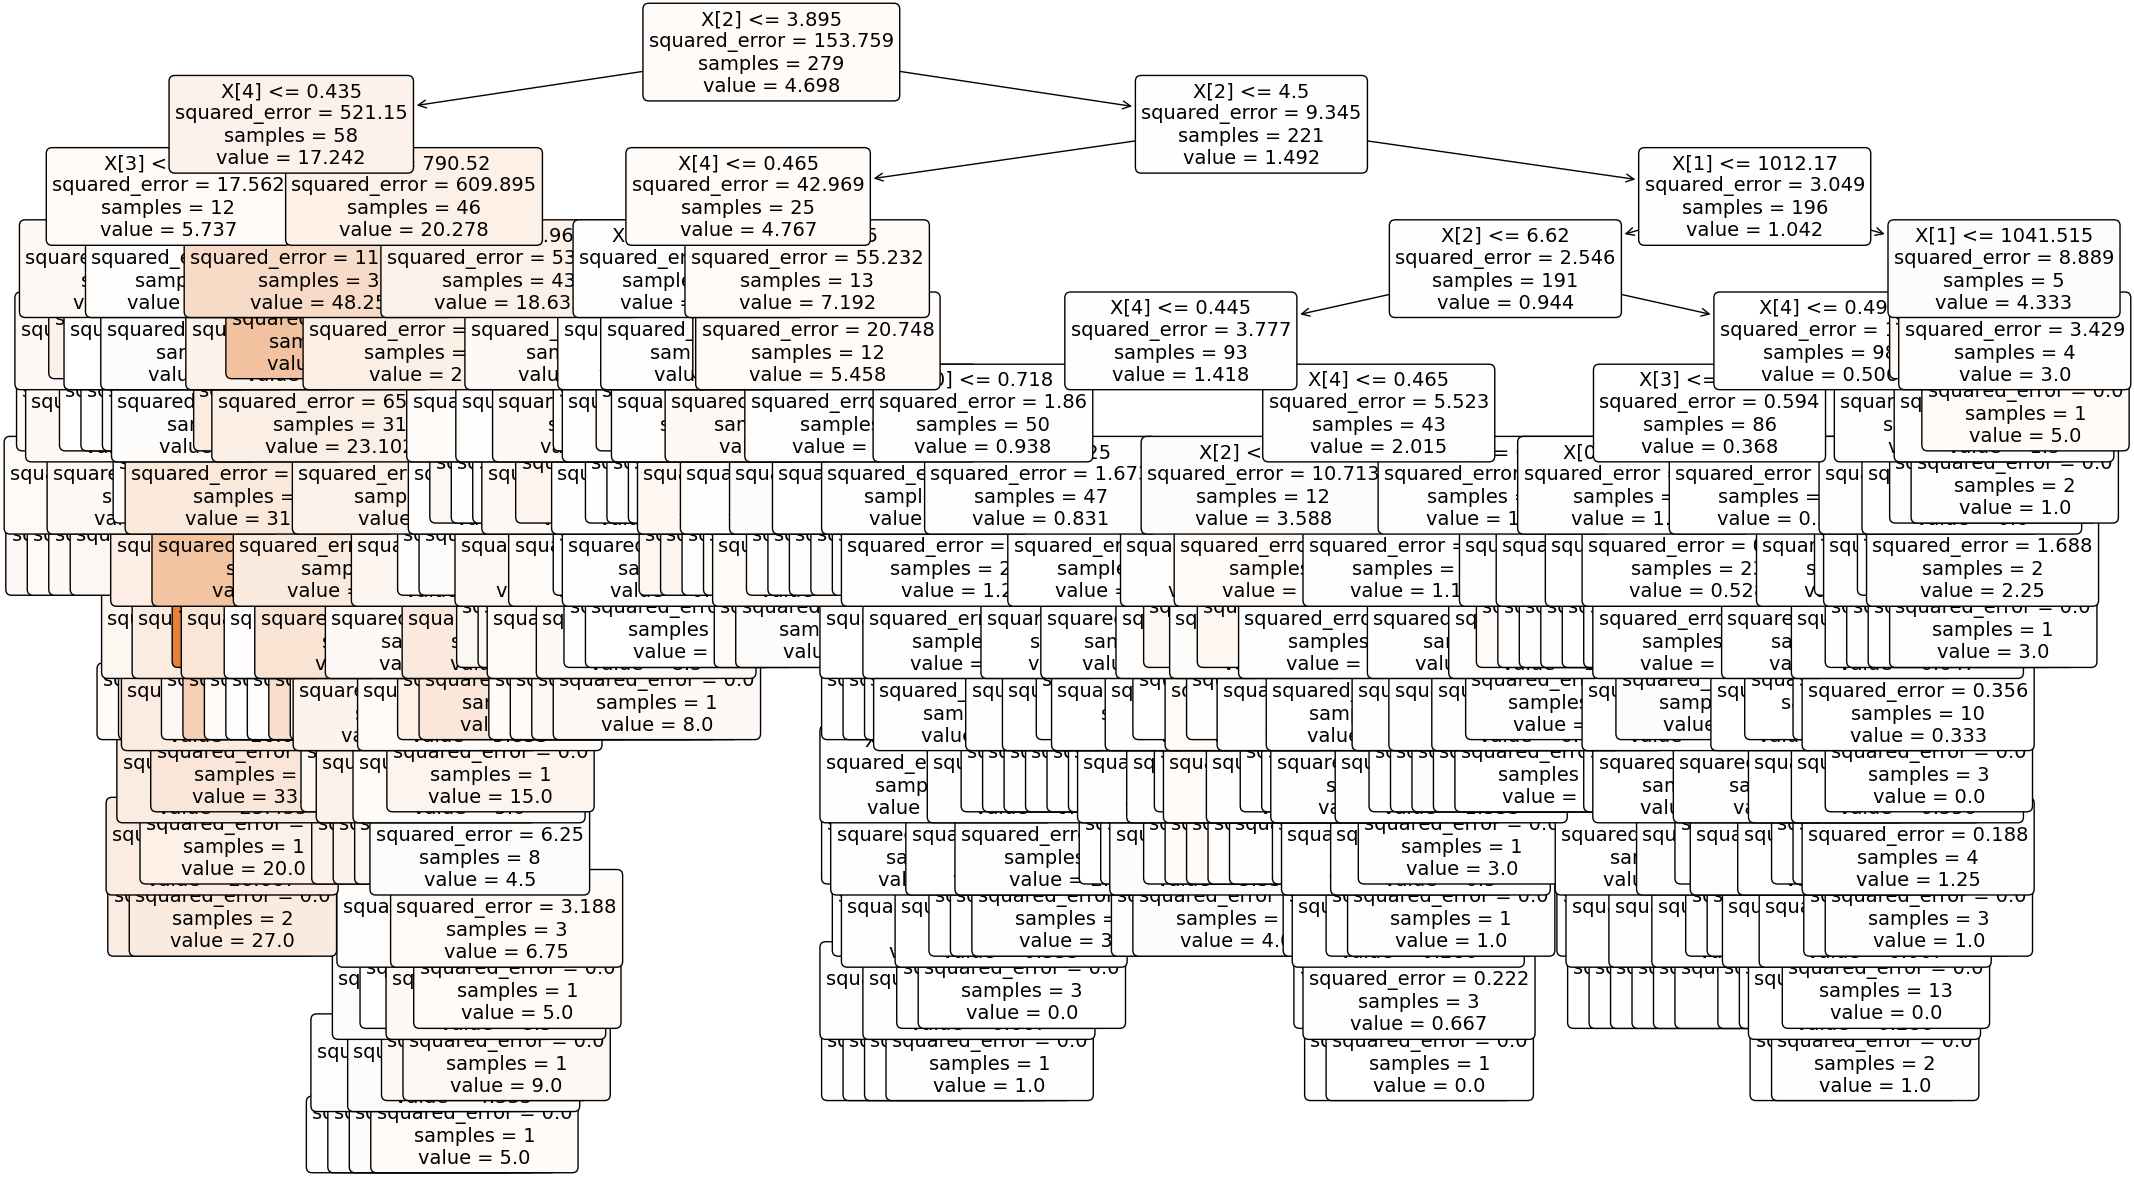

In [173]:
%matplotlib inline

Tree = regressor.estimators_[5] #escolhendo uma árvore
plt.figure(figsize=(25,15))
tree.plot_tree(Tree,filled=True, 
              rounded=True, 
              fontsize=14)

plt.show()